# An introductory note

This notebook serves as the one place where you can find out everything about bioscrape inference -- use cases, features, debugging, and development. A basic familiarity with probability distributions, Bayesian inference and Markov Chain Monte Carlo (MCMC) is assumed. To learn about the internal programming details of running an MCMC algorithm, refer to the `emcee_tutorial.ipynb`. 

# Let's start with a simple example - A linear model

Consider the linear model: y = mx + b and let's create an artificial data set for this model by adding noise to its simulation:

(this example is taken from emcee package documentation and modified to be used with bioscrape inference)

In [15]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20

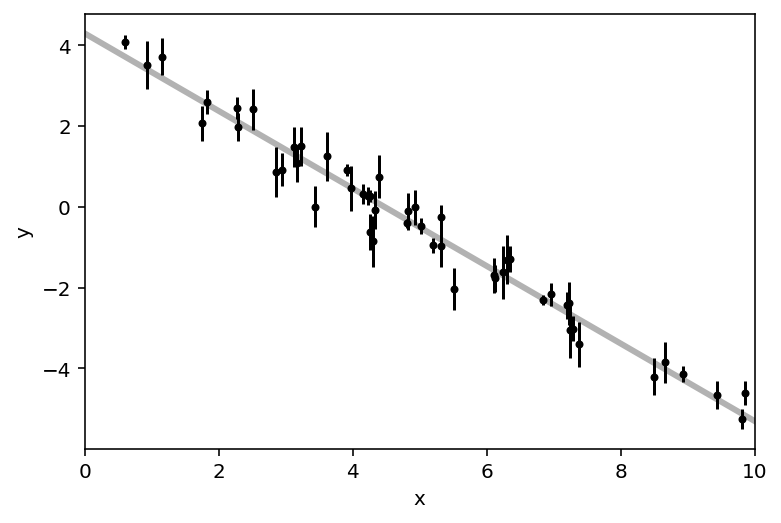

In [2]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(123)

# Choose the "true" parameters.
m_true = -0.9594
b_true = 4.294
# f_true = 0.534
from bioscrape.types import Model
from bioscrape.simulator import py_simulate_model

species = ['y']
parameters = {'m':m_true, 'b': b_true}
rule = ('assignment',{'equation':'y = _m*t + _b'})
x0 = {'y':0}
M = Model(species = species, parameters = parameters, rules = [rule], initial_condition_dict = x0)


#Simulate the Model deterministically
x0 = np.linspace(0, 10, 50)
results_det = py_simulate_model(x0, Model = M) #Returns a Pandas DataFrame

# Generate some synthetic data from the model.
N = 50
x = np.sort(10 * np.random.rand(N))
yerr = 0.1 + 0.6 * np.random.rand(N)
y = m_true * x + b_true
# y += np.abs(f_true * y) * np.random.randn(N)
y += yerr * np.random.randn(N)

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
x0 = np.linspace(0, 10, 50)
plt.plot(x0, results_det['y'], "k", alpha=0.3, lw=3)
plt.xlim(0, 10)
plt.xlabel('x')
plt.ylabel('y');

Bioscrape uses Pandas dataframe to provide simulation results and also to load data. Here's how to create a Pandas dataframe object for our artificial data above:


In [3]:
import pandas as pd
exp_data = pd.DataFrame()
exp_data['x'] = x0
exp_data['y'] = y
exp_data

,x,y
0,0.000000,4.081221
1,0.204082,3.508320
2,0.408163,3.715964
3,0.612245,2.069505
4,0.816327,2.598509
5,1.020408,2.450301
6,1.224490,1.986717
7,1.428571,2.415742
8,1.632653,0.870627
9,1.836735,0.922192


## Now we are ready to use bioscrape inference to estimate parameter distributions for our linear model given the artificial data:

C:\Users\apand\AppData\Local\Continuum\anaconda3\lib\site-packages\emcee\ensemble.py:258: RuntimeWarning: Initial state is not linearly independent and it will not allow a full exploration of parameter space
  category=RuntimeWarning,
100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 216.41it/s]


Successfully completed MCMC parameter identification procedure. Parameter distribution data written to mcmc_results.csv file. Check the MCMC diagnostics to evaluate convergence.
{'Autocorrelation time for each parameter': array([31.97829852, 29.79149282]), 'Acceptance fraction (fraction of steps that were accepted)': array([0.713 , 0.717 , 0.7305, 0.703 , 0.7275, 0.7135, 0.715 , 0.717 ,
       0.6985, 0.7185, 0.7345, 0.7135, 0.723 , 0.698 , 0.7085, 0.7325,
       0.697 , 0.7175, 0.7255, 0.727 , 0.709 , 0.728 , 0.7195, 0.701 ,
       0.7225, 0.713 , 0.7215, 0.721 , 0.725 , 0.7215, 0.7135, 0.7085])}
Parameter posterior distribution convergence plots:


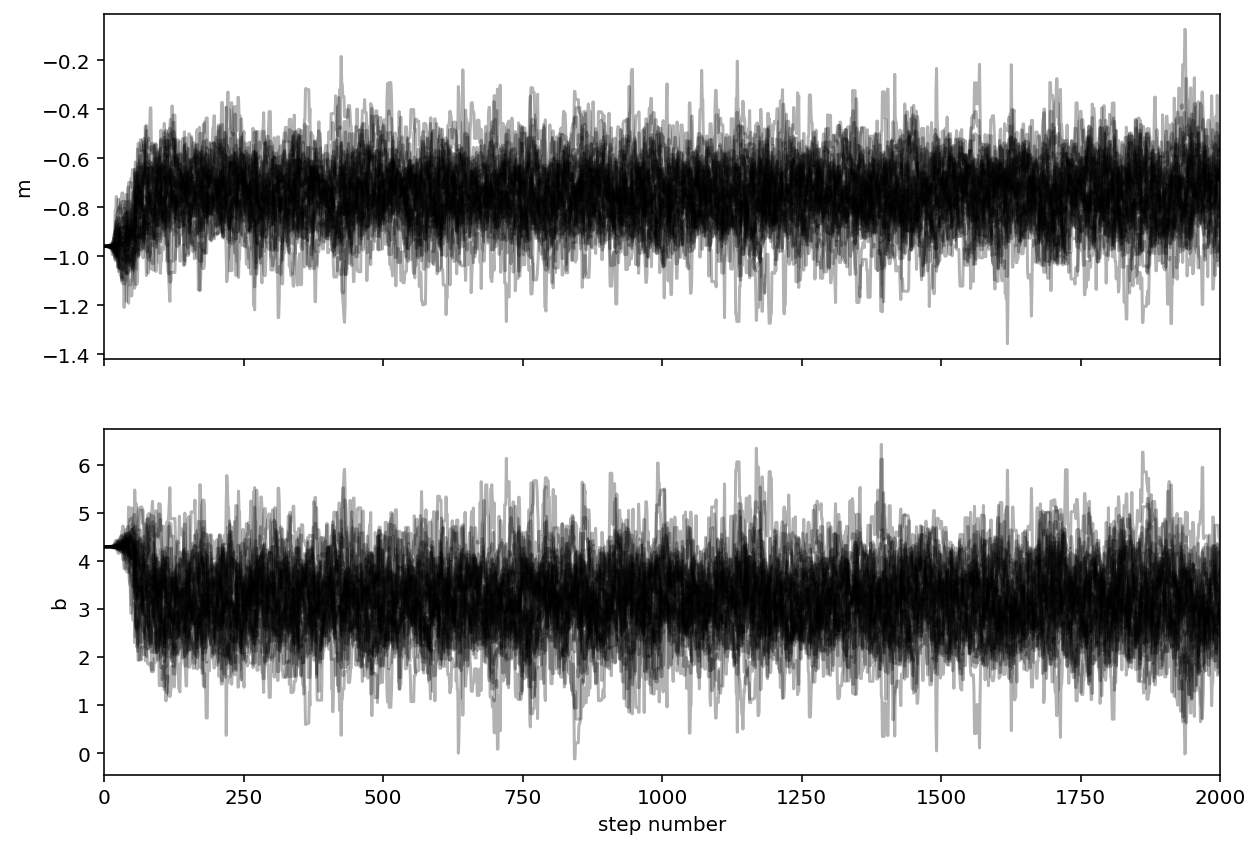

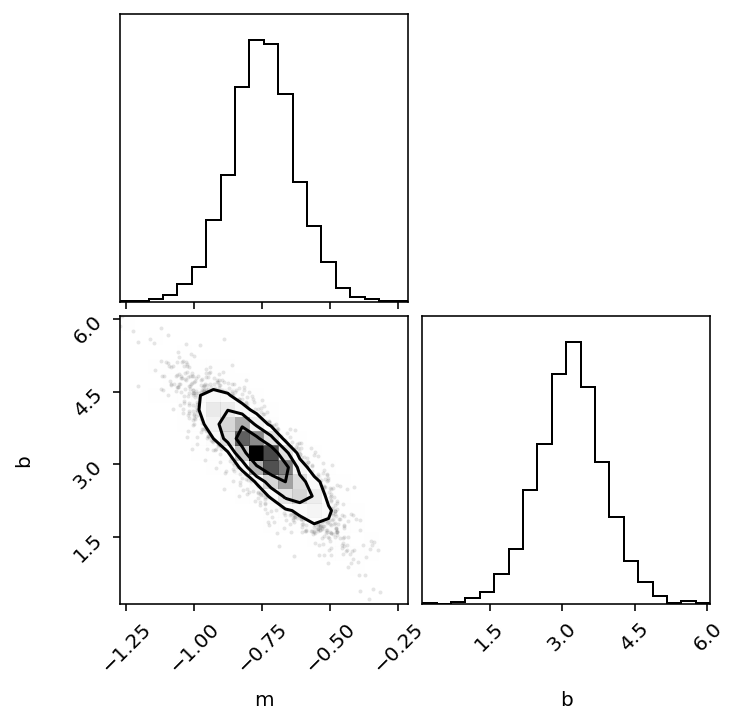

In [4]:
# from bioscrape.pid_interfaces import 
from bioscrape.inference import py_inference

# Import data from CSV
# Import a CSV file for each experiment run
prior = {'m' : ['gaussian', m_true, 500],'b' : ['gaussian', b_true, 1000]}
sampler, pid = py_inference(Model = M, exp_data = exp_data, measurements = ['y'],
                     time_column = ['x'], params_to_estimate = ['m','b'],
                      nwalkers = 32, nsteps = 2000, init_seed = 1e-4, prior = prior,
                      sim_type = 'deterministic', plot_show = False)

# Recommended to simply use sampler object/mcmc_results.csv and generate your own custom plots
truth_list, uncertainty_list = pid.plot_mcmc_results(sampler);

Finally, let us use the samples from the posterior distributions of the parameters alongside our original model and the data:

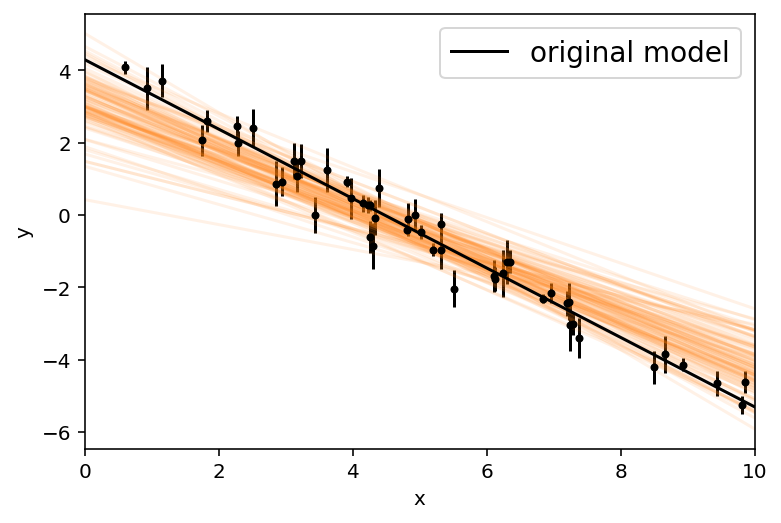

In [6]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x0, np.dot(np.vander(x0, 2), sample[:2]), "C1", alpha=0.1)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", label="original model")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

Great! That's our first MCMC run using Bioscrape. Let us try some more examples to learn about various Bioscrape Inference features. We start by making a slightly more complicated model:

# A Birth-Death Model

## $\emptyset \xrightarrow[]{k_1} X \; \; \; \; X \xrightarrow[]{d_1} \emptyset$

This time instead of creating the model from scratch, we import an **SBML** model into Bioscrape. SBML is the standard language used to write biological models. Here we have the SBML file "toy_sbml_model.xml" in our path already. For details on how to create this file using Bioscrape, refer to the "Basic Examples -- START HERE.ipynb" in `bioscrape/examples`. 

100%|█████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:05<00:00, 535.92it/s]


Successfully completed MCMC parameter identification procedure. Parameter distribution data written to mcmc_results.csv file. Check the MCMC diagnostics to evaluate convergence.
{'Autocorrelation time for each parameter': array([34.90999633]), 'Acceptance fraction (fraction of steps that were accepted)': array([0.796     , 0.81166667, 0.79733333, 0.79433333, 0.80466667])}
Parameter posterior distribution convergence plots:


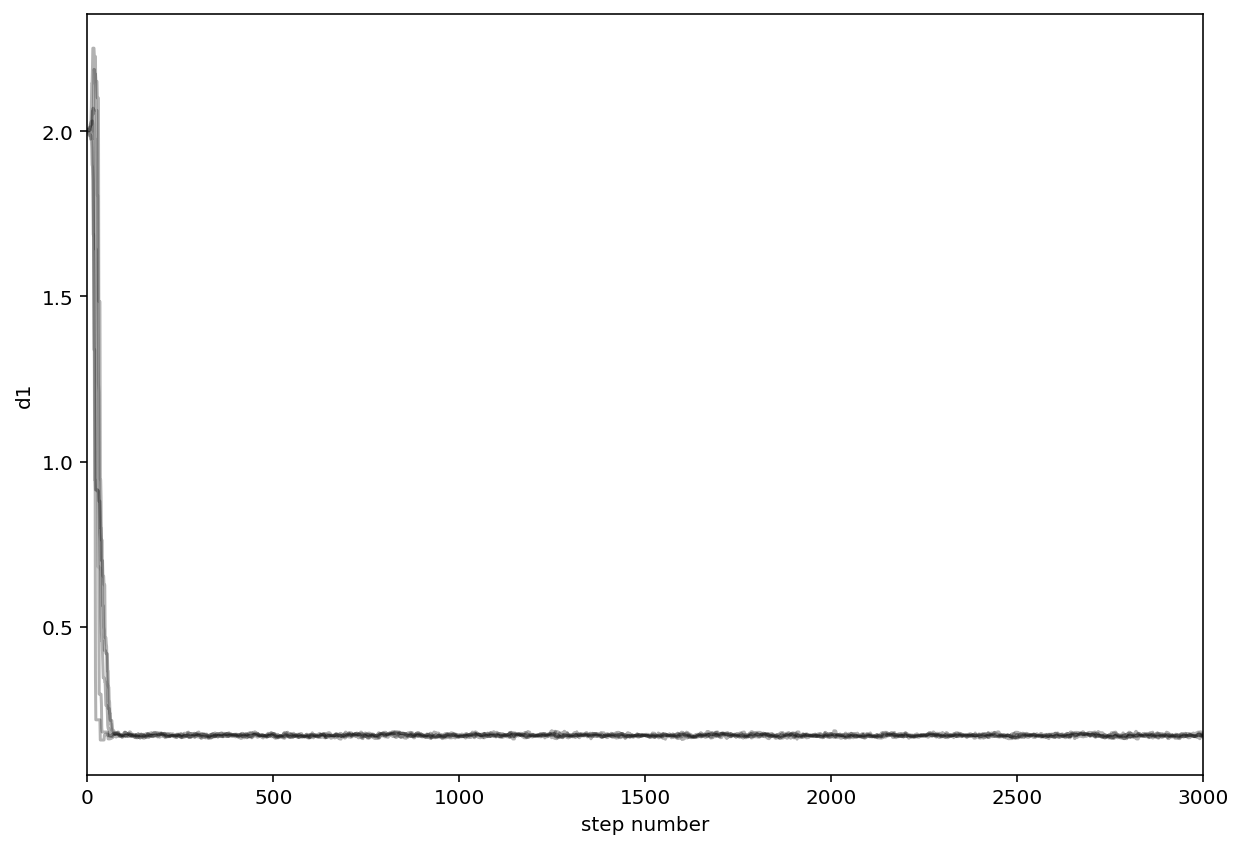

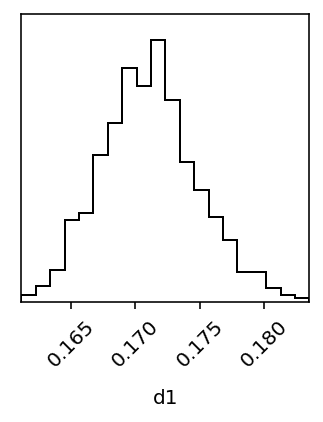

In [7]:
import bioscrape as bs
from bioscrape.types import Model
from bioscrape.inference import py_inference
import numpy as np
import pylab as plt
import pandas as pd
# Import a bioscrape/SBML model
M = Model(sbml_filename = 'toy_sbml_model.xml')
# Import data from CSV
# Import a CSV file for each experiment run
df = pd.read_csv('test_data.csv', delimiter = '\t', names = ['X','time'], skiprows = 1)
M.set_species({'X':df['X'][0]})

# Create prior for parameters
prior = {'d1' : ['gaussian', 0.2, 200]}
sampler, pid = py_inference(Model = M, exp_data = df, measurements = ['X'], time_column = ['time'],
            nwalkers = 5, init_seed = np.array([2]), nsteps = 3000, sim_type = 'deterministic',
            params_to_estimate = ['d1'], prior = prior)


Note that we only estimated one parameter here - $d$, and for that parameter we created a Gaussian distribution prior. Bioscrape inference provides plenty of probability distributions built-in to be used as parameter prior distributions. To learn more refer to the "Priors in Bioscrape Inference.ipynb" in `bioscrape/inference examples/`. Now, let us try to estimate both the parameters of our birth-death model:

100%|█████████████████████████████████████████████████████████████████████████████| 5500/5500 [00:38<00:00, 142.12it/s]


Successfully completed MCMC parameter identification procedure. Parameter distribution data written to mcmc_results.csv file. Check the MCMC diagnostics to evaluate convergence.
{'Autocorrelation time for each parameter': array([69.75409722, 69.44887778]), 'Acceptance fraction (fraction of steps that were accepted)': array([0.64854545, 0.65054545, 0.62745455, 0.63036364, 0.66418182,
       0.64581818, 0.66018182, 0.63236364, 0.63127273, 0.64436364,
       0.64890909, 0.64545455, 0.64218182, 0.63945455, 0.636     ,
       0.64290909, 0.644     , 0.63727273, 0.63781818, 0.66509091])}
Parameter posterior distribution convergence plots:


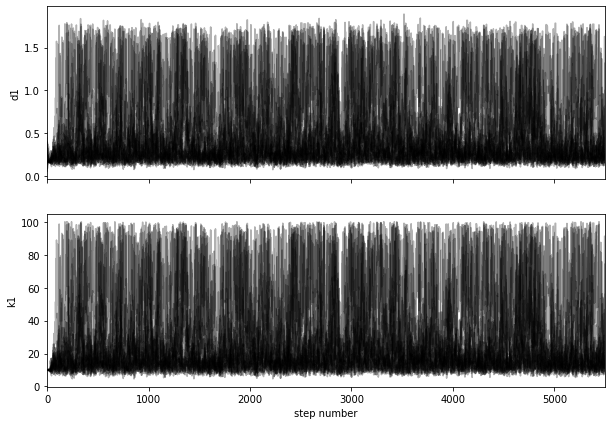

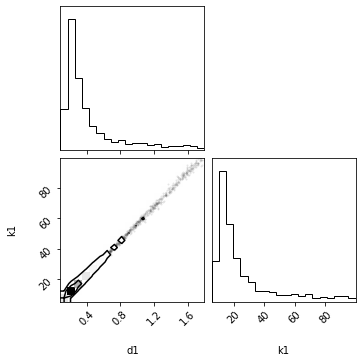

In [7]:
import bioscrape as bs
from bioscrape.types import Model
from bioscrape.inference import py_inference

import numpy as np
import pylab as plt
import pandas as pd
# Import a bioscrape/SBML model
M = Model(sbml_filename = 'toy_sbml_model.xml')
# Import data from CSV
# Import a CSV file for each experiment run
df = pd.read_csv('test_data.csv', delimiter = '\t', names = ['X','time'], skiprows = 1)
M.set_species({'X':df['X'][0]})

prior = {'d1' : ['gaussian', 0.2, 20], 'k1' : ['uniform', 0, 100]}

sampler, pid = py_inference(Model = M, exp_data = df, measurements = ['X'], time_column = ['time'],
            nwalkers = 20, init_seed = 0.15, nsteps = 5500, sim_type = 'deterministic',
            params_to_estimate = ['d1', 'k1'], prior = prior)


## Tip: All of the MCMC run results are written to the `mcmc_results.csv` file after a run. You can check that file out to run your own analysis!.

A common scenario with parameter estimation is that we usually have replicates of the data leading to multiple trajectories in the data that need to be fitted to a single model at the same time. Bioscrape inference allows for such a use case natively. Simply send in more data! Here's how: (let's first generate data with multiple trajectories)

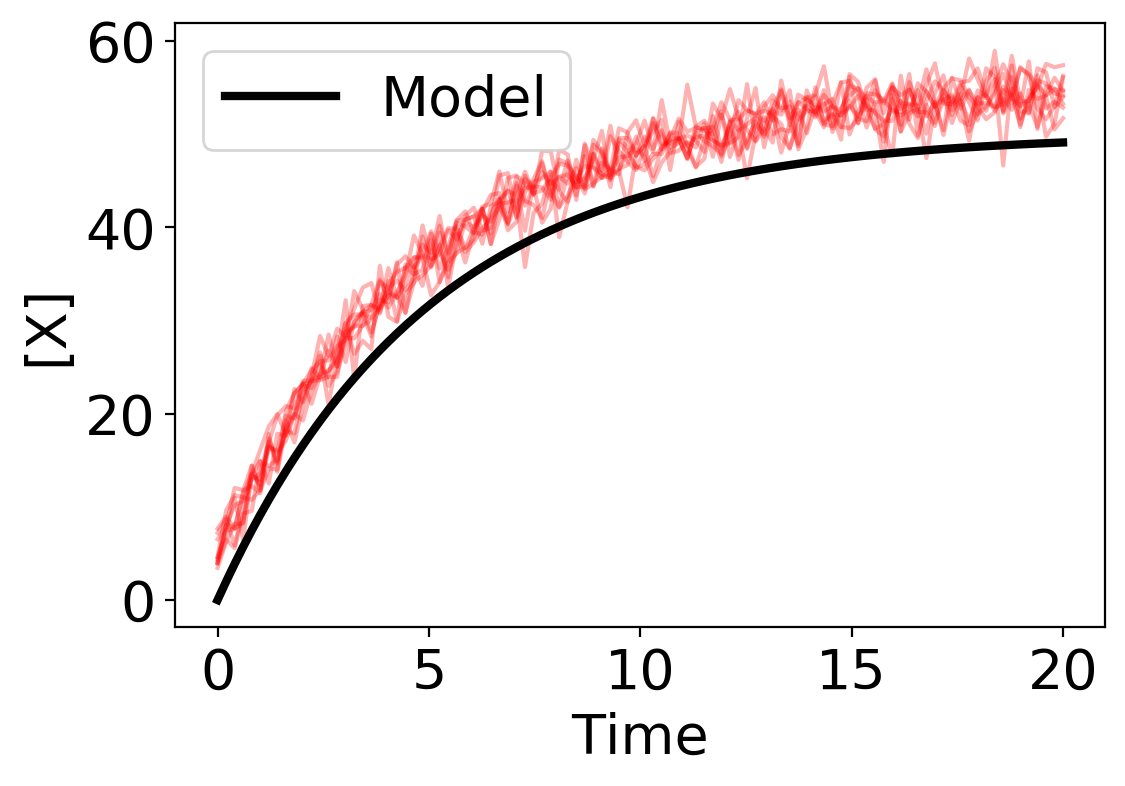

In [6]:

M = Model(sbml_filename = 'toy_sbml_model.xml')
timepoints = np.linspace(0,20,100)
result = py_simulate_model(timepoints, Model = M)['X']

num_trajectories = 10
exp_data = pd.DataFrame()
exp_data['timepoints'] = timepoints
for i in range(num_trajectories):
    exp_data['X' + str(i)] = result + np.random.normal(5, 2, size = np.shape(result))
    plt.plot(timepoints, exp_data['X' + str(i)], 'r', alpha = 0.3)
plt.plot(timepoints, result, 'k', linewidth = 3, label = 'Model')
plt.legend()
plt.xlabel('Time')
plt.ylabel('[X]')
plt.show()


In [9]:
exp_data.to_csv('birth_death_data.csv')
exp_data

,timepoints,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9
0,0.000000,0.971762,4.781580,3.965340,4.494378,4.171635,5.511020,7.111915,3.790713,7.542507,4.937664
1,0.202020,8.877286,8.530480,5.724722,6.854626,6.994307,7.867249,7.521869,8.351503,5.117242,9.718728
2,0.404040,8.430279,8.925585,10.924723,10.648831,10.234794,9.420153,5.948018,8.856819,10.439571,10.605345
3,0.606061,7.240696,13.465320,11.556788,11.674499,11.570305,10.463961,12.562844,10.915195,10.471024,10.979217
4,0.808081,10.421336,13.384598,12.767432,15.930179,13.140790,15.668570,11.554880,10.126967,11.762553,11.576668
5,1.010101,17.859085,18.538739,13.778419,11.235463,14.846028,14.939613,14.080459,11.430355,15.458362,13.884653
6,1.212121,20.713773,16.613789,16.505686,17.988068,18.078893,10.230630,14.469217,14.642853,13.686978,14.675908
7,1.414141,15.319308,18.281452,17.476047,17.060526,18.326128,19.825027,15.716413,15.525685,17.516758,17.802146
8,1.616162,18.066465,15.336341,21.143639,19.589136,17.563410,17.528455,14.850120,19.771876,17.977409,18.814003
9,1.818182,18.475188,20.853706,21.822794,19.414710,19.498915,17.978119,18.334507,20.084194,17.718229,19.481026


With that data written to a CSV file, we can load that CSV file and run inference:

  0%|                                                                                         | 0/4000 [00:00<?, ?it/s]C:\Users\apand\AppData\Local\Continuum\anaconda3\lib\site-packages\emcee\moves\red_blue.py:97: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [01:01<00:00, 65.30it/s]


Successfully completed MCMC parameter identification procedure. Parameter distribution data written to mcmc_results.csv file. Check the MCMC diagnostics to evaluate convergence.
{'Autocorrelation time for each parameter': array([76.67055152, 73.31032342]), 'Acceptance fraction (fraction of steps that were accepted)': array([0.67875, 0.7105 , 0.71075, 0.698  , 0.70775])}
Parameter posterior distribution convergence plots:


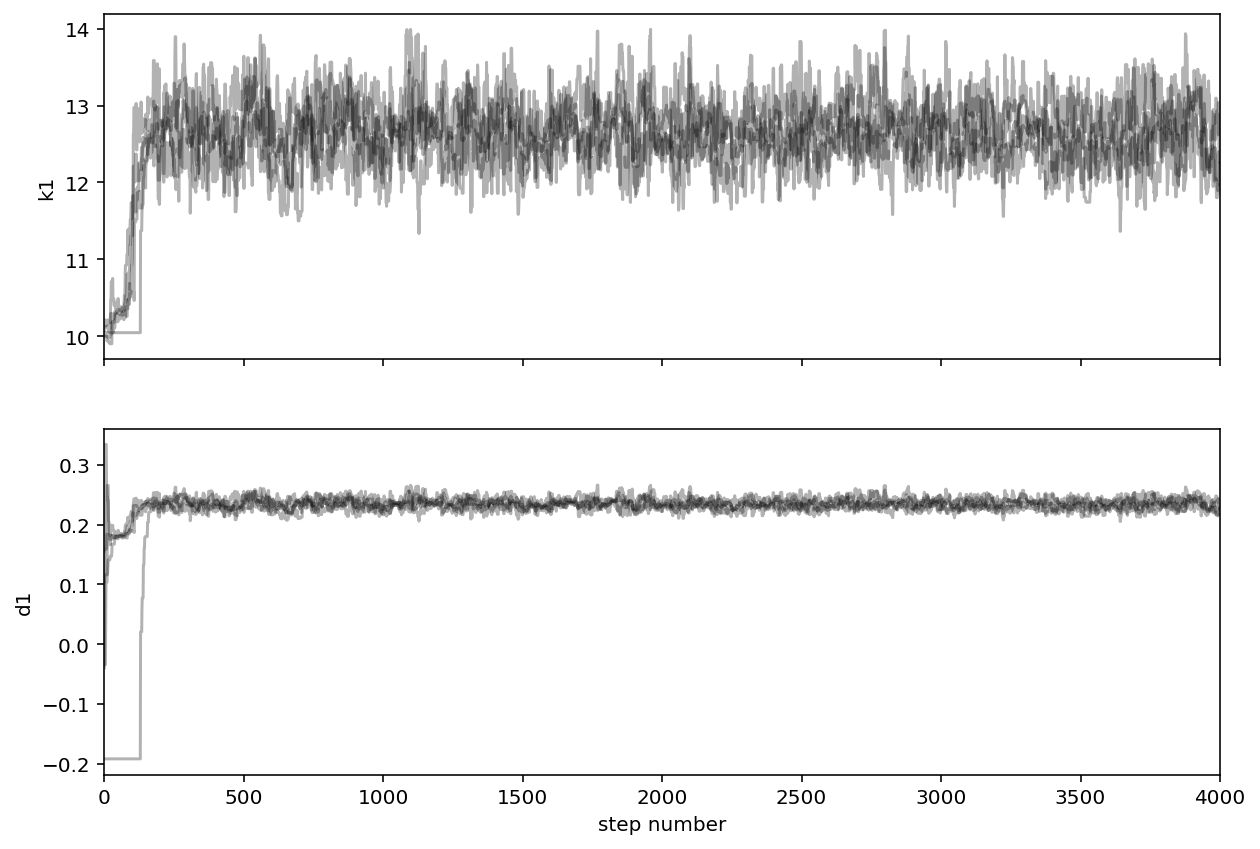

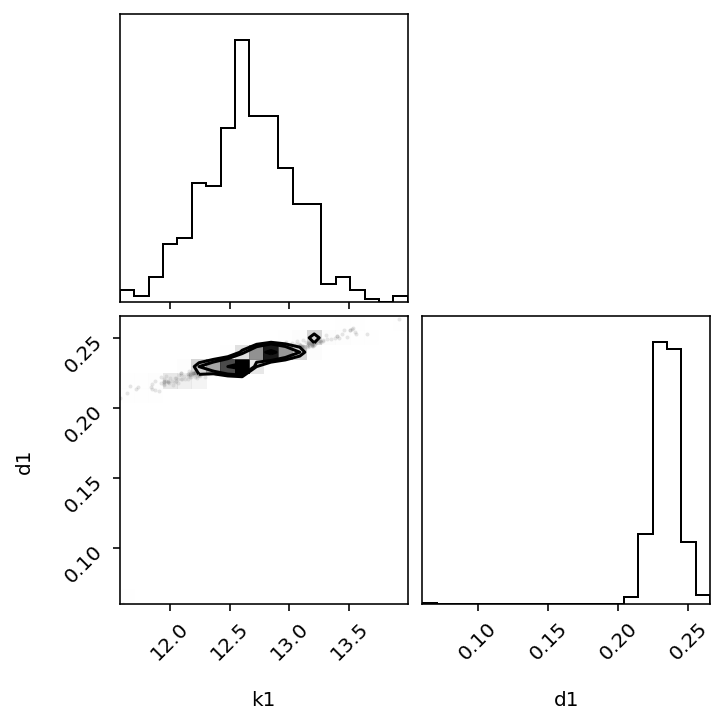

In [12]:
from bioscrape.inference import py_inference
# Import data from CSV
# Import a CSV file for each experiment run
exp_data = []
for i in range(num_trajectories):
    df = pd.read_csv('birth_death_data.csv', usecols = ['timepoints', 'X'+str(i)])
    df.columns = ['timepoints', 'X']
    exp_data.append(df)
 
prior = {'k1' : ['uniform', 0, 100],'d1' : ['uniform',0,10]}

sampler, pid = py_inference(Model = M, exp_data = exp_data, measurements = ['X'], time_column = ['timepoints'],
            nwalkers = 5, init_seed = 0.15, nsteps = 4000, sim_type = 'deterministic',
            params_to_estimate = ['k1', 'd1'], prior = prior)


### Note: A bioscrape inference run using `py_inference` returns a tuple consisting of the `sampler` and a `pid` object. The `sampler` is a emcee object that can be used for any post-processing whereas `pid` is the bioscrape inference object that consists of all of your previous settings. You can use these returned objects for post processing and plotting as follows:

Parameter posterior distribution convergence plots:


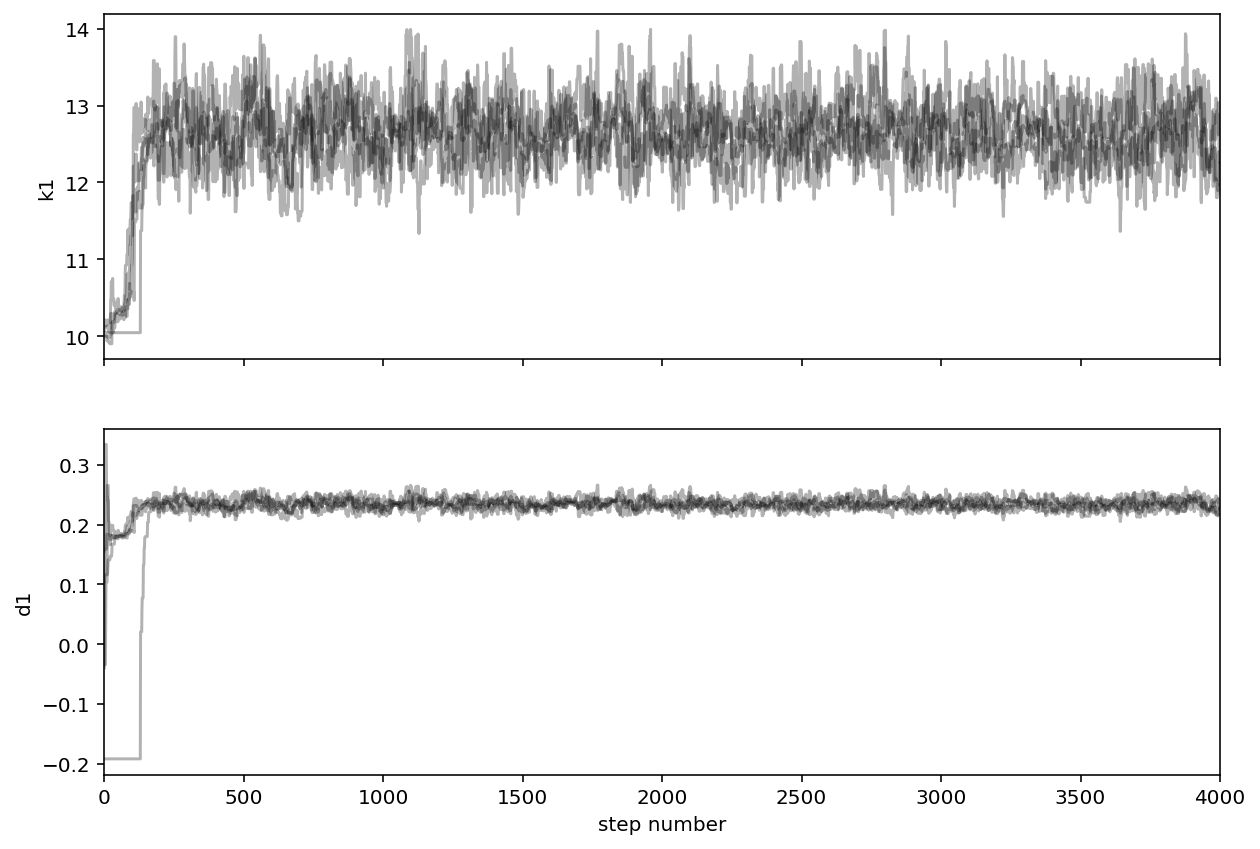

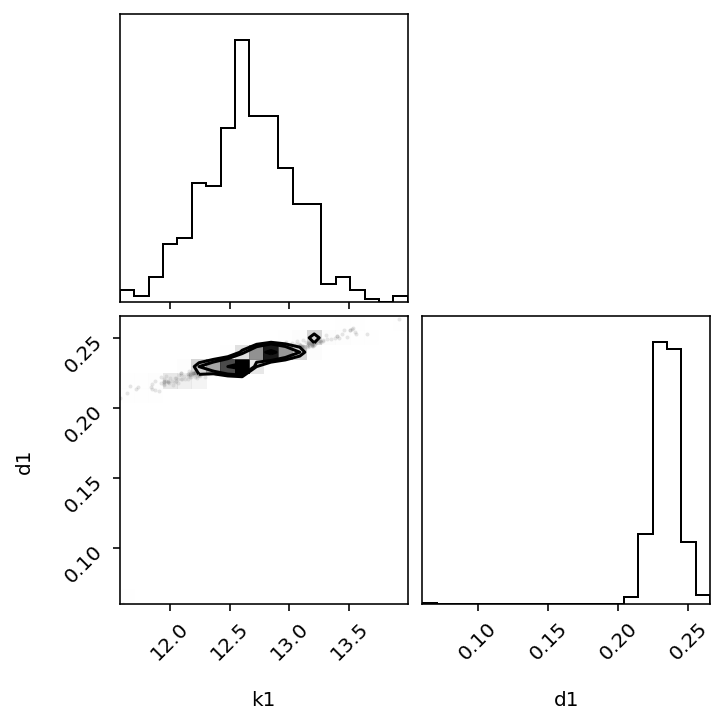

In [13]:
pid.plot_mcmc_results(sampler);

As before, we can sample the posterior distribution and run the simulations for this fitted model alongside the data:

C:\Users\apand\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Depricated Warning: Bioscrape XML is being replaced by SBML and will no longer be supported in a future version of the software.
  """Entry point for launching an IPython kernel.


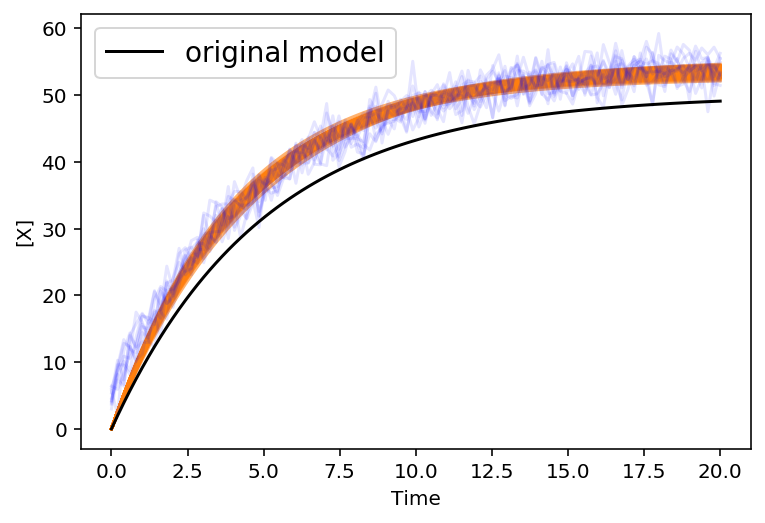

In [14]:
M_fit = Model('toy_model.xml')
timepoints = pid.timepoints[0]
flat_samples = sampler.get_chain(discard=200, thin=15, flat=True)
inds = np.random.randint(len(flat_samples), size=200)
for ind in inds:
    sample = flat_samples[ind]
    for pi, pi_val in zip(pid.params_to_estimate, sample):
        M_fit.set_parameter(pi, pi_val)
    plt.plot(timepoints, py_simulate_model(timepoints, Model= M_fit)['X'], "C1", alpha=0.6)
# plt.errorbar(, y, yerr=yerr, fmt=".k", capsize=0)
for i in range(num_trajectories):
    plt.plot(timepoints, list(pid.exp_data[i]['X']), 'b', alpha = 0.1)
plt.plot(timepoints, result, "k", label="original model")
plt.legend(fontsize=14)
plt.xlabel("Time")
plt.ylabel("[X]");

# Starting the MCMC chain at different initial points (init_seed):

The `init_seed` keyword argument to `py_inference` can be either of the two things:
* A float value - In this case, the float value passed is used as the scaling factor for a Gaussian ball around the initial parameter values already set in the Bioscrape Model object.
* A numpy array - In this case, you can directly pass the initial parameter values to the sampler. This array consists of the values where the sampler starts sampling.

## Tip: Start at different initial conditions for your parameters and if you end up in the same region you can have higher confidence on convergence of your chain.

Let's try a different initial seed for the above example

C:\Users\apand\AppData\Local\Continuum\anaconda3\lib\site-packages\emcee\ensemble.py:258: RuntimeWarning: Initial state is not linearly independent and it will not allow a full exploration of parameter space
  category=RuntimeWarning,
100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:56<00:00, 70.25it/s]


Successfully completed MCMC parameter identification procedure. Parameter distribution data written to mcmc_results.csv file. Check the MCMC diagnostics to evaluate convergence.
{'Autocorrelation time for each parameter': array([14.92858836, 33.99481667]), 'Acceptance fraction (fraction of steps that were accepted)': array([0.6995 , 0.71225, 0.69725, 0.68875, 0.70575])}
Parameter posterior distribution convergence plots:


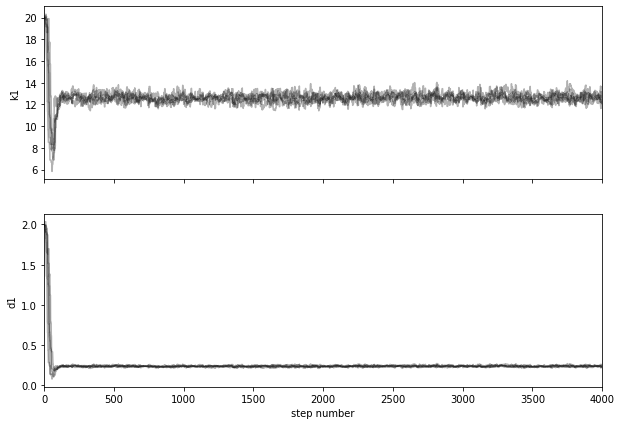

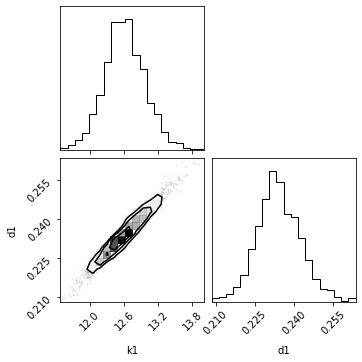

In [10]:
from bioscrape.inference import py_inference
# Import data from CSV
# Import a CSV file for each experiment run
exp_data = []
for i in range(num_trajectories):
    df = pd.read_csv('birth_death_data.csv', usecols = ['timepoints', 'X'+str(i)])
    df.columns = ['timepoints', 'X']
    exp_data.append(df)
 
prior = {'k1' : ['uniform', 0, 100],'d1' : ['uniform',0,10]}

sampler, pid = py_inference(Model = M, exp_data = exp_data, measurements = ['X'], time_column = ['timepoints'],
            nwalkers = 5, init_seed = np.array([20, 2]), nsteps = 4000, sim_type = 'deterministic',
            params_to_estimate = ['k1', 'd1'], prior = prior)


## An inner look:

Bioscrape inference computes a cost that is used as the likelihood function for emcee. The MCMC chain aims to minimize this cost. An invaluable tool when running Bayesian inference could be to look at the progression of this cost. This may help you in judging the convergence of the MCMC sampler. On the topic of convergence, as you may have noted in our earlier inference runs, a list of convergence related statistics is printed after the run finishes successfully. Make sure to learn more about these MCMC convergence diagnostics to understand better if your inference run has converged or not. Here is how to check the cost progress:

### Likelihood cost progress (with number of steps in the chain):

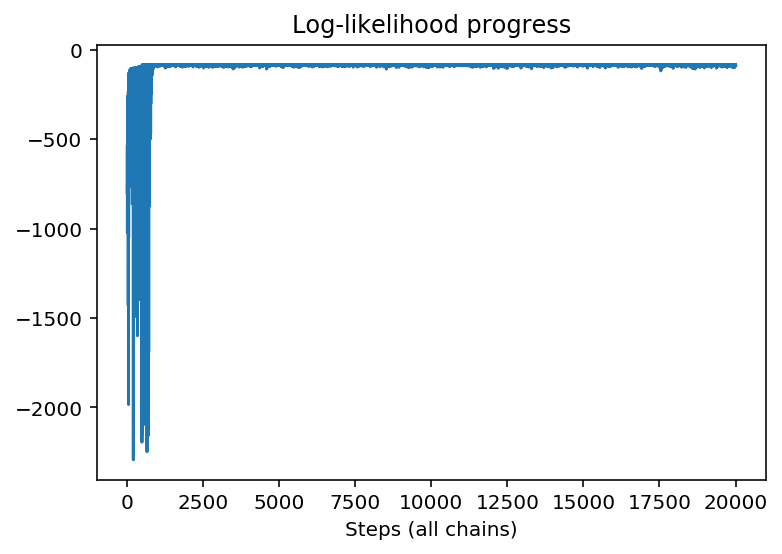

In [15]:
plt.close()
plt.title('Log-likelihood progress')
plt.plot(pid.cost_progress)
plt.xlabel('Steps (all chains)')
plt.show()

Now that we have seen how to use multiple data trajectories with bioscrape inference, what if those trajectories are under different initial conditions?

# Multiple Initial Conditions:

In our birth-death model, we introduce an inducer species that we will use to demonstrate the effect of different initial conditions.
## $\emptyset \xrightarrow[]{k_1(I)} X \; \; \; \; X \xrightarrow[]{d_1} \emptyset$


## $ k_1(I) = \frac{k_1 I^2}{K_R^2 + I^2}$

Here $I$ is the inducer species that may have different initial conditions. 

In [21]:
import bioscrape as bs
from bioscrape.types import Model
from bioscrape.simulator import py_simulate_model

import numpy as np
import pylab as plt
import pandas as pd
species = ['I','X']
reactions = [(['X'], [], 'massaction', {'k':'d1'}), 
             ([], ['X'], 'hillpositive', {'s1':'I', 'k':'k1', 'K':'KR', 'n':2})]
k1 = 50.0
d1 = 0.5
params = [('k1', k1), ('d1', d1), ('KR', 20)]
initial_condition = {'X':0, 'I':0}
M = Model(species = species, reactions = reactions, parameters = params, 
          initial_condition_dict = initial_condition)

### Generate experimental data for multiple initial conditions
1. Simulate bioscrape model
2. Add Gaussian noise of non-zero mean and non-zero variance to the simulation
3. Create appropriate Pandas dataframes 
4. Write the data to a CSV file

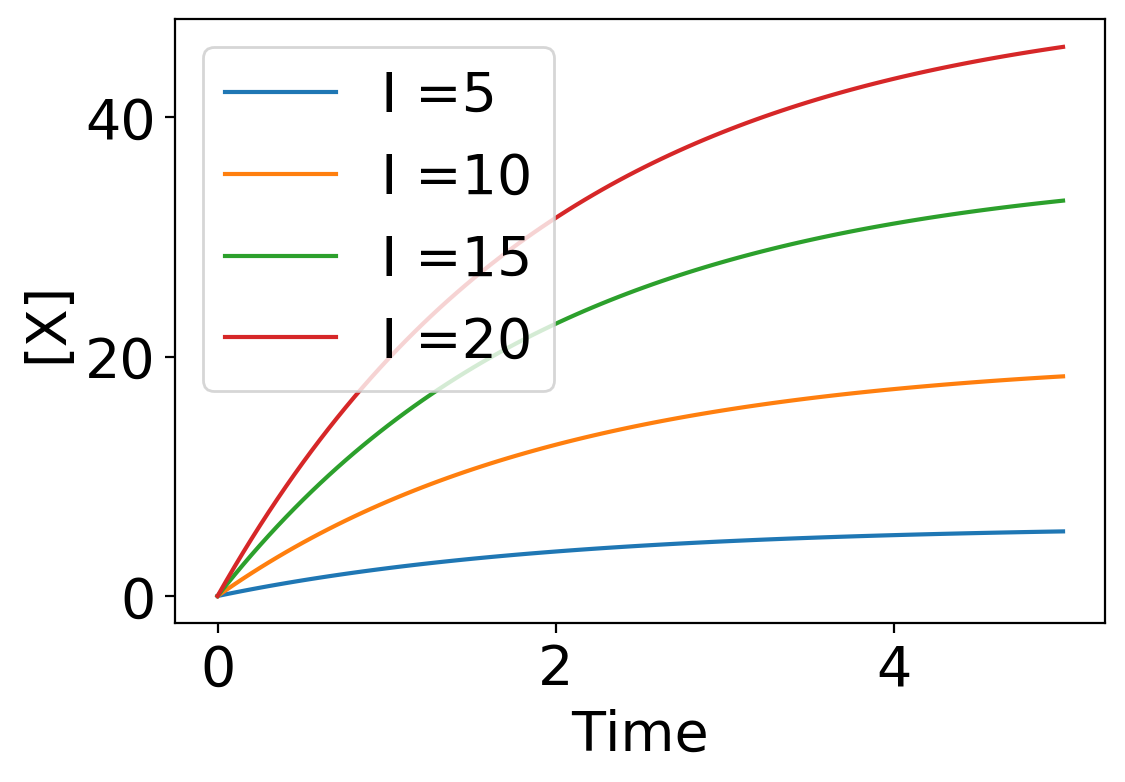

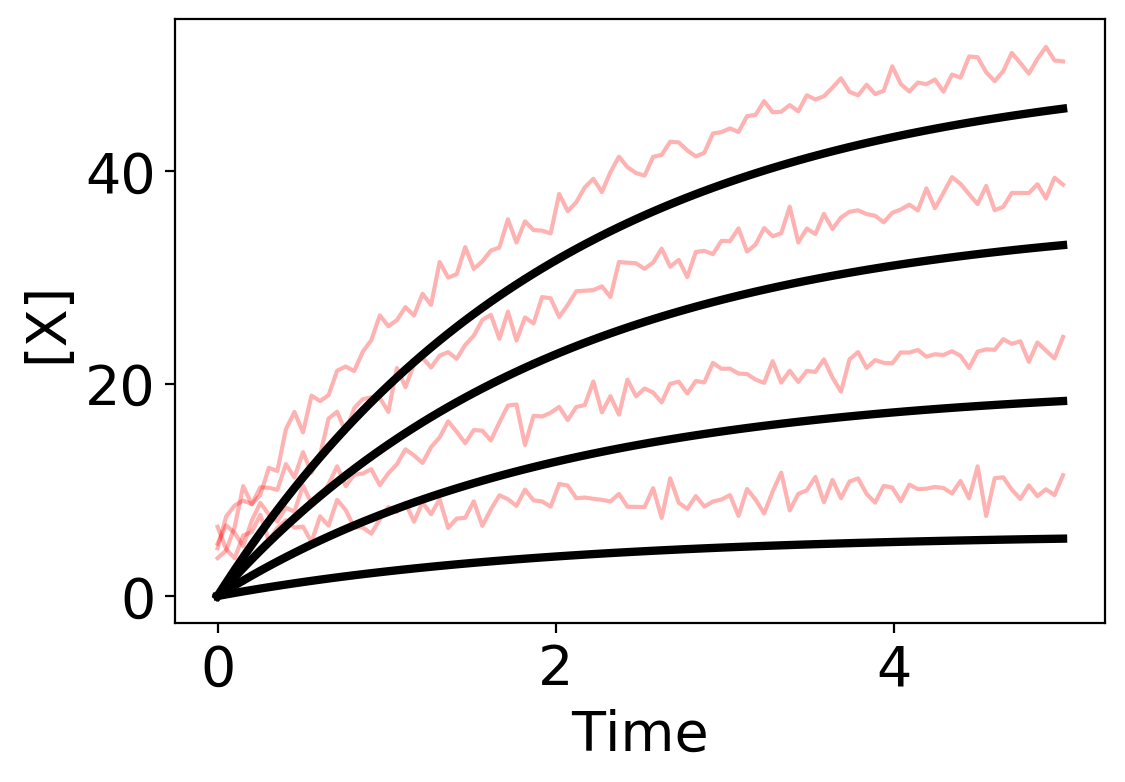

In [22]:

num_trajectories = 4 # each with different initial condition
initial_condition_list = [{'I':5},{'I':10},{'I':15},{'I':20}] 
timepoints = np.linspace(0,5,100)
result_list = []
for init_cond in initial_condition_list:
    M.set_species(init_cond)
    result = py_simulate_model(timepoints, Model = M)['X']
    result_list.append(result)
    plt.plot(timepoints, result, label = 'I =' + str(list(init_cond.values())[0]))
plt.xlabel('Time')
plt.ylabel('[X]')
plt.legend()
plt.show()

exp_data = pd.DataFrame()
exp_data['timepoints'] = timepoints
for i in range(num_trajectories):
    exp_data['X' + str(i)] = result_list[i] + np.random.normal(5, 1, size = np.shape(result))
    plt.plot(timepoints, exp_data['X' + str(i)], 'r', alpha = 0.3)
    plt.plot(timepoints, result_list[i], 'k', linewidth = 3)
plt.xlabel('Time')
plt.ylabel('[X]')
plt.show()
exp_data.to_csv('birth_death_data_multiple_conditions.csv')

In [23]:
exp_data

,timepoints,X0,X1,X2,X3
0,0.000000,6.518394,4.927645,3.567521,4.493148
1,0.050505,4.413151,6.656202,4.277206,7.472501
2,0.101010,3.548899,5.935851,6.493505,8.525489
3,0.151515,5.697214,4.690261,10.344496,8.986877
4,0.202020,6.026134,7.089534,8.630392,8.673177
5,0.252525,7.651086,8.765731,10.233628,9.489084
6,0.303030,5.200932,7.685171,10.192695,12.067848
7,0.353535,6.414101,7.010806,9.998592,11.771407
8,0.404040,7.139509,8.320872,12.420707,15.701580
9,0.454545,6.436146,7.938477,11.156251,17.329745


## Now run bioscrape inference...

100%|█████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:23<00:00, 169.93it/s]


Successfully completed MCMC parameter identification procedure. Parameter distribution data written to mcmc_results.csv file. Check the MCMC diagnostics to evaluate convergence.
{'Autocorrelation time for each parameter': array([27.69600755]), 'Acceptance fraction (fraction of steps that were accepted)': array([0.80475, 0.8105 , 0.80275, 0.796  , 0.80575])}
Parameter posterior distribution convergence plots:


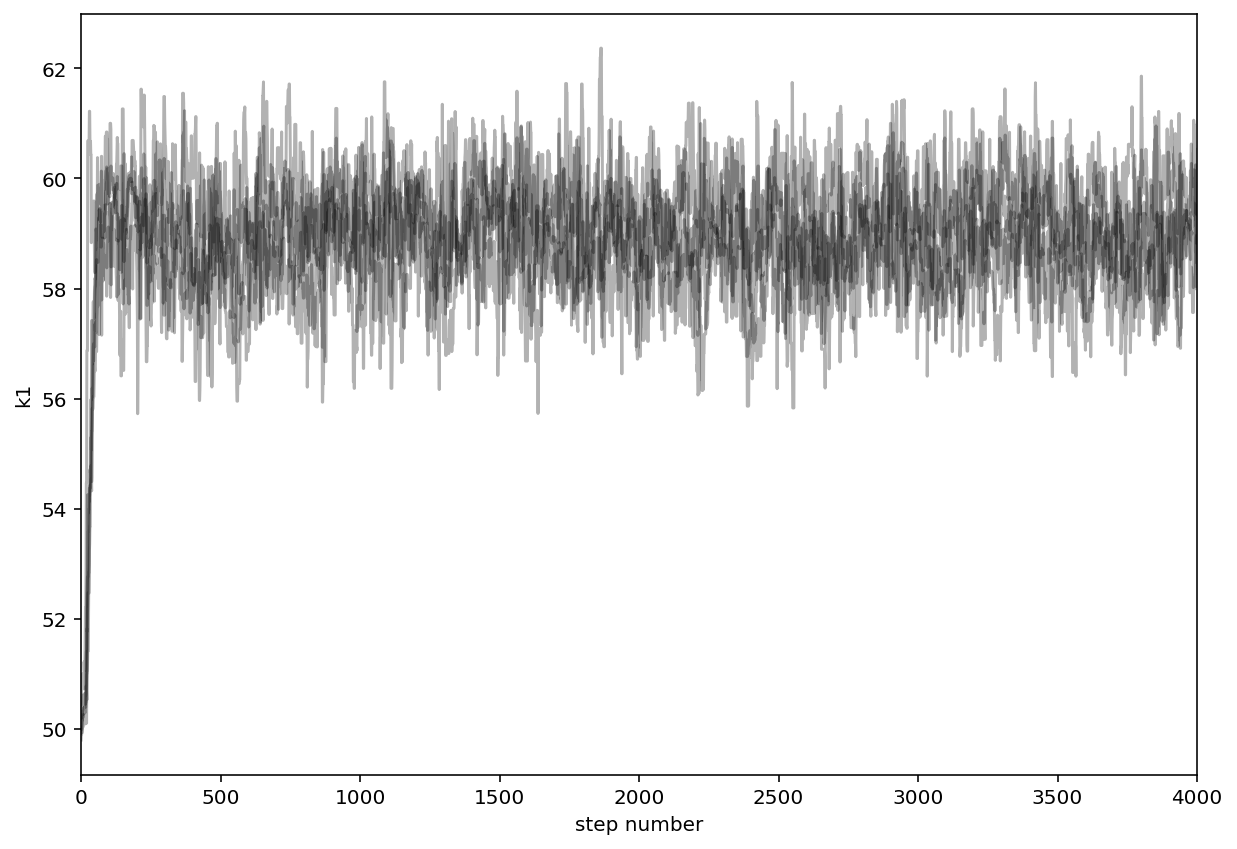

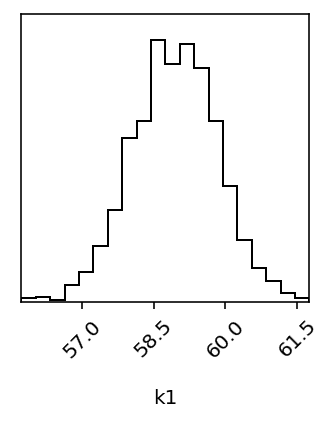

In [21]:
from bioscrape.inference import py_inference
# Import data from CSV
# Import a CSV file for each experiment run
exp_data = []
for i in range(num_trajectories):
    df = pd.read_csv('birth_death_data_multiple_conditions.csv', usecols = ['timepoints', 'X'+str(i)])
    df.columns = ['timepoints', 'X']
    exp_data.append(df)
    
prior = {'k1' : ['uniform', 0, 100]}

sampler, pid = py_inference(Model = M, exp_data = exp_data, measurements = ['X'], time_column = ['timepoints'],
                            initial_conditions = initial_condition_list,
                            nwalkers = 5, init_seed = 0.15, nsteps = 4000, sim_type = 'deterministic',
                            params_to_estimate = ['k1'], prior = prior)


As before...

### Check mcmc_results.csv for the results of the MCMC procedure and perform your own analysis.

### OR

### You can also plot the results as follows

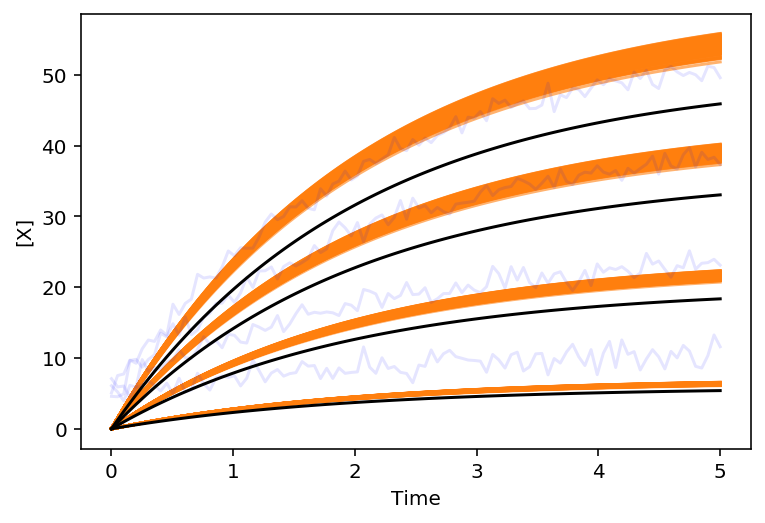

In [22]:
M_fit = M
timepoints = pid.timepoints[0]
flat_samples = sampler.get_chain(discard=200, thin=15, flat=True)
inds = np.random.randint(len(flat_samples), size=200)
for init_cond in initial_condition_list:
    
    for ind in inds:
        sample = flat_samples[ind]
        for pi, pi_val in zip(pid.params_to_estimate, sample):
            M_fit.set_parameter(pi, pi_val)
        M_fit.set_species(init_cond)
        plt.plot(timepoints, py_simulate_model(timepoints, Model= M_fit)['X'], "C1", alpha=0.6)
# plt.errorbar(, y, yerr=yerr, fmt=".k", capsize=0)
for i in range(num_trajectories):
    plt.plot(timepoints, list(pid.exp_data[i]['X']), 'b', alpha = 0.1)
    plt.plot(timepoints, result_list[i], "k")
# plt.legend(fontsize=14)
plt.xlabel("Time")
plt.ylabel("[X]");

### Let us now try to fit all three parameters to see if results improve:

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:58<00:00, 85.54it/s]


Successfully completed MCMC parameter identification procedure. Parameter distribution data written to mcmc_results.csv file. Check the MCMC diagnostics to evaluate convergence.
{'Autocorrelation time for each parameter': array([43.69469163, 42.26596952, 45.63147305]), 'Acceptance fraction (fraction of steps that were accepted)': array([0.6414, 0.6378, 0.646 , 0.6356, 0.6364, 0.6462, 0.6408, 0.642 ,
       0.6424, 0.6362])}
Parameter posterior distribution convergence plots:


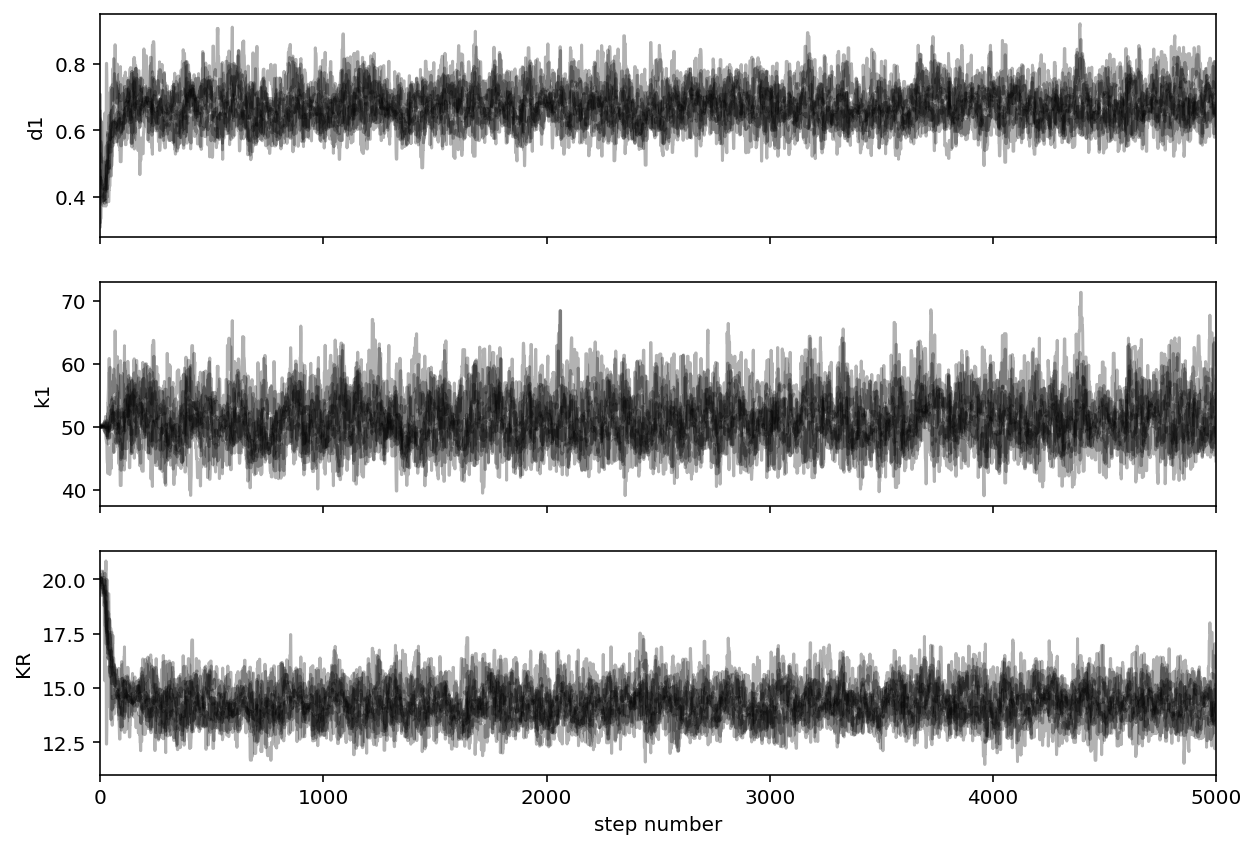

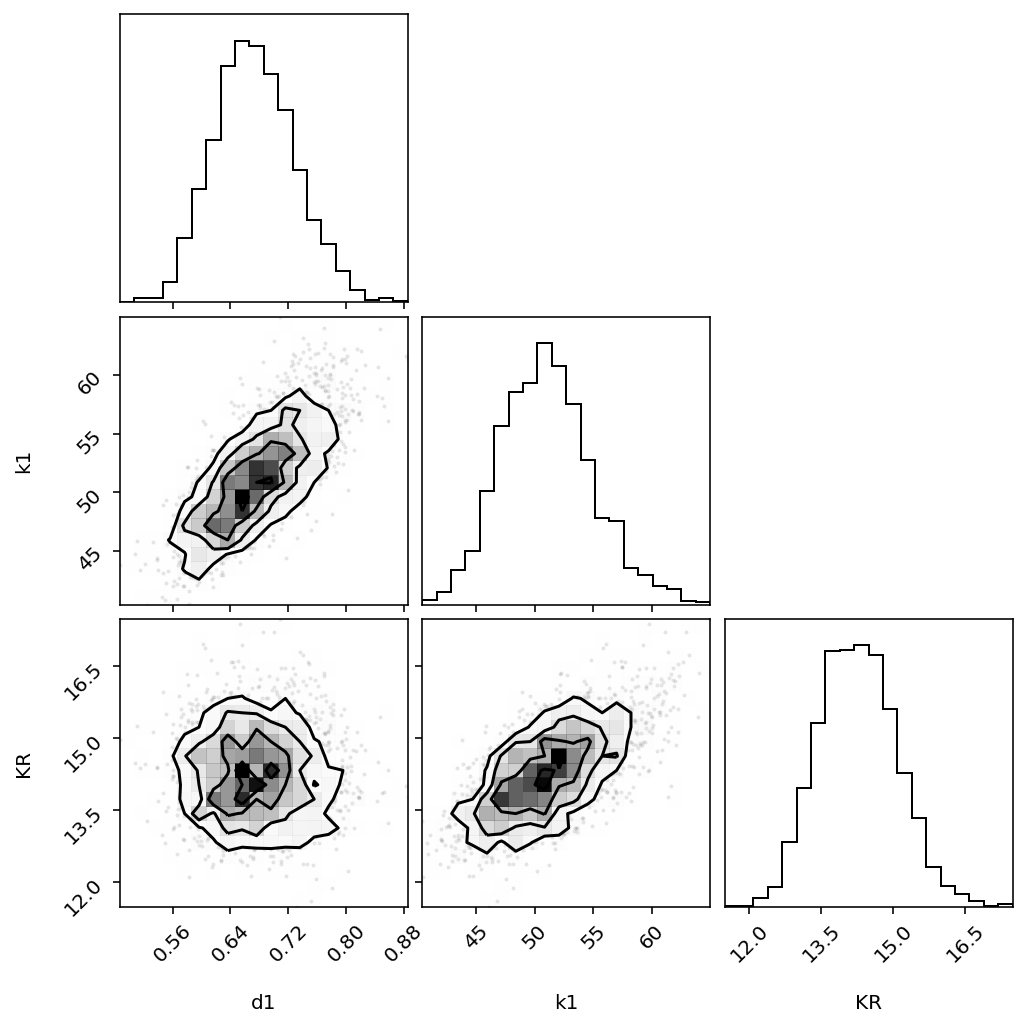

In [23]:
M = Model(species = species, reactions = reactions, parameters = params, 
          initial_condition_dict = initial_condition)
prior = {'d1' : ['uniform', 0.1, 10], 'k1' : ['uniform',0,100], 'KR' : ['uniform',0,100]}

sampler, pid = py_inference(Model = M, exp_data = exp_data, measurements = ['X'], time_column = ['timepoints'],
                            initial_conditions = initial_condition_list,
                            nwalkers = 10, init_seed = 0.15, nsteps = 5000, sim_type = 'deterministic',
                            params_to_estimate = ['d1','k1','KR'], prior = prior)


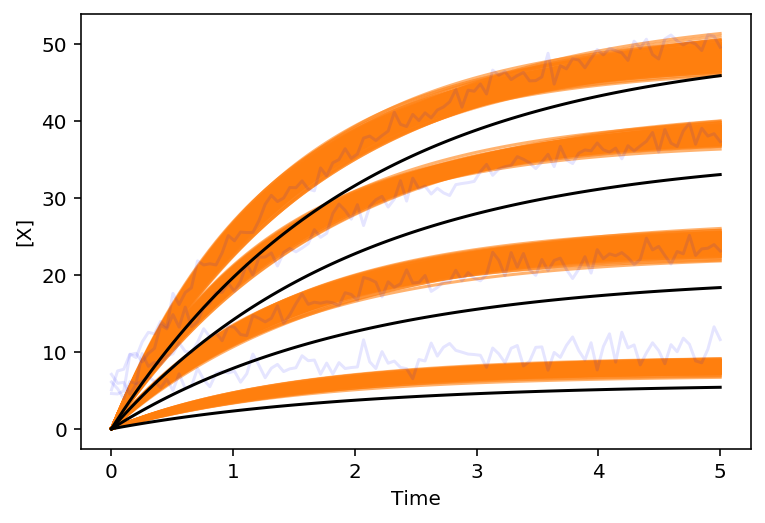

In [24]:
M_fit = M
timepoints = pid.timepoints[0]
flat_samples = sampler.get_chain(discard=200, thin=15, flat=True)
inds = np.random.randint(len(flat_samples), size=200)
for init_cond in initial_condition_list:
    for ind in inds:
        sample = flat_samples[ind]
        for pi, pi_val in zip(pid.params_to_estimate, sample):
            M_fit.set_parameter(pi, pi_val)
        M_fit.set_species(init_cond)
        plt.plot(timepoints, py_simulate_model(timepoints, Model= M_fit)['X'], "C1", alpha=0.6)
# plt.errorbar(, y, yerr=yerr, fmt=".k", capsize=0)
for i in range(num_trajectories):
    plt.plot(timepoints, list(pid.exp_data[i]['X']), 'b', alpha = 0.1)
    plt.plot(timepoints, result_list[i], "k")
# plt.legend(fontsize=14)
plt.xlabel("Time")
plt.ylabel("[X]");

In the thread of multiple data trajectories, another common possibility is to have multiple measured species in the data. This is the case when you have measurements for more than one species in the model and you want to fit your model so that it performs well on both measurements. Bioscrape inference allows for this possibility natively. Here's how:

# Multiple Measurements and Initial Conditions (together)

Let's change our model slightly for this to make sense.
## $\emptyset \xrightarrow[]{k_1(I)} X \; \; \; \; X \xrightarrow[]{d_1} \emptyset$
## $X \xrightarrow[]{k_2} Y$

## $ k_1(I) = \frac{k_1 I^2}{K_R^2 + I^2}$

In [13]:
%matplotlib inline
import bioscrape as bs
from bioscrape.types import Model
from bioscrape.simulator import py_simulate_model

import numpy as np
import pylab as plt
import pandas as pd
species = ['I','X', 'Y']
reactions = [(['X'], [], 'massaction', {'k':'d1'}), 
             ([], ['X'], 'hillpositive', {'s1':'I', 'k':'k1', 'K':'KR', 'n':2}),
             (['X'],['Y'],'massaction', {'k':'k2'})]
k1 = 50.0
d1 = 0.5
k2 = 10
params = [('k1', k1), ('d1', d1), ('KR', 20), ('k2',k2)]
initial_condition = {'X':0, 'I':0}
M = Model(species = species, reactions = reactions, parameters = params, 
          initial_condition_dict = initial_condition)

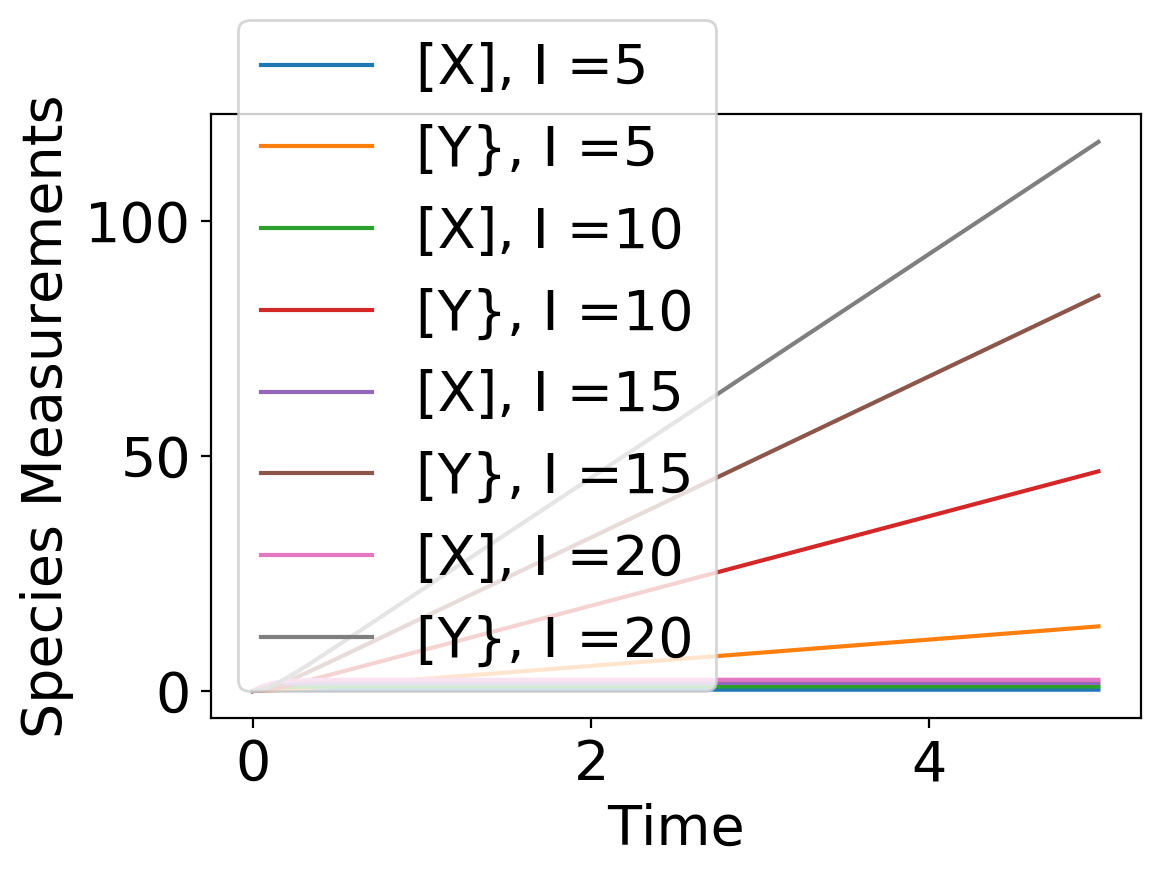

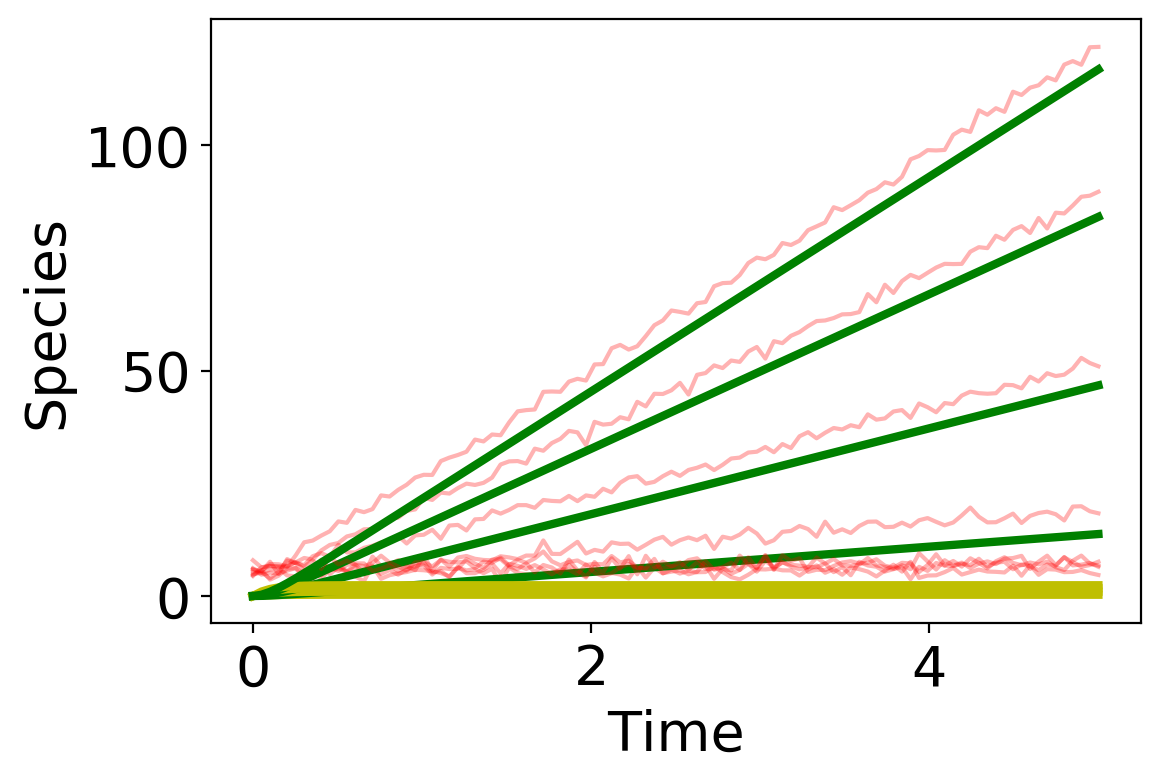

In [19]:
num_trajectories = 4 # each with different initial condition
initial_condition_list = [{'I':5},{'I':10},{'I':15},{'I':20}] 
timepoints = np.linspace(0,5,100)
result_list = []
for init_cond in initial_condition_list:
    M.set_species(init_cond)
    result = py_simulate_model(timepoints, Model = M)
    result_list.append(result)
    plt.plot(timepoints, result['X'], label = '[X], I =' + str(list(init_cond.values())[0]))
    plt.plot(timepoints, result['Y'], label = '[Y}, I =' + str(list(init_cond.values())[0]))
plt.xlabel('Time')
plt.ylabel('Species Measurements')
plt.legend()
plt.show()

exp_data = pd.DataFrame()
exp_data['timepoints'] = timepoints
for i in range(num_trajectories):
    exp_data['X' + str(i)] = result_list[i]['X'] + np.random.normal(5, 1, size = np.shape(result['X']))
    exp_data['Y' + str(i)] = result_list[i]['Y'] + np.random.normal(5, 1, size = np.shape(result['Y']))
    plt.plot(timepoints, exp_data['X' + str(i)], 'r', alpha = 0.3)
    plt.plot(timepoints, exp_data['Y' + str(i)], 'r', alpha = 0.3)
    plt.plot(timepoints, result_list[i]['X'], 'y', linewidth = 3)
    plt.plot(timepoints, result_list[i]['Y'], 'g', linewidth = 3)
plt.xlabel('Time')
plt.ylabel('Species')
plt.show()
exp_data.to_csv('multiple_measurements.csv')


Here's how the CSV file looks:

In [13]:
exp_data

,timepoints,X0,Y0,X1,Y1,X2,Y2,X3,Y3
0,0.000000,5.487288,3.422314,4.017831,6.478233,5.480513,5.484171,5.175188,4.105939
1,0.050505,6.722182,5.571410,4.228253,4.034593,6.339790,3.675744,6.266816,4.852587
2,0.101010,4.323515,4.898409,6.147602,6.079358,7.842048,6.686716,7.413983,6.425333
3,0.151515,4.611715,5.805203,5.519495,4.430942,6.166440,6.543486,7.287451,5.432831
4,0.202020,7.353271,4.452315,6.375591,5.429470,7.255534,4.960908,8.184943,8.905535
5,0.252525,5.141828,7.827106,5.772083,5.971911,7.890692,8.895501,7.472910,9.068886
6,0.303030,3.462704,7.031662,4.616092,6.908281,8.524812,7.530628,7.424613,9.150779
7,0.353535,6.579833,5.225839,5.557104,8.030327,6.495875,9.524954,7.175637,10.983952
8,0.404040,5.365966,6.922086,7.569141,8.610046,7.146094,9.459990,7.791596,13.004135
9,0.454545,5.589312,5.183440,5.103390,8.241978,6.138085,11.124510,6.379729,12.986328


Now, we load this CSV file in the appropriate format (a list of dataframes where each dataframe corresponds to an initial condition and each dataframe consists of both measurements $X$ and $Y$)

In [14]:
exp_data = []
for i in range(num_trajectories):
    df = pd.read_csv('multiple_measurements.csv', usecols = ['timepoints', 'X'+str(i),'Y'+str(i)])
    df.columns = ['timepoints', 'X', 'Y']
    exp_data.append(df)

  0%|                                                                                         | 0/4000 [00:00<?, ?it/s]C:\Users\apand\AppData\Local\Continuum\anaconda3\lib\site-packages\emcee\moves\red_blue.py:97: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:55<00:00, 71.84it/s]
C:\Users\apand\AppData\Local\Continuum\anaconda3\lib\site-packages\emcee\autocorr.py:38: RuntimeWarning: invalid value encountered in true_divide
  acf /= acf[0]
C:\Users\apand\AppData\Local\Continuum\anaconda3\lib\site-packages\emcee\autocorr.py:43: RuntimeWarning: invalid value encountered in less
  m = np.arange(len(taus)) < c * taus
C:\Users\apand\AppData\Local\Continuum\anaconda3\lib\site-packages\emcee\autocorr.py:101: RuntimeWarning: invalid value encountered in greater
  flag = tol * tau_est > n_t


Successfully completed MCMC parameter identification procedure. Parameter distribution data written to mcmc_results.csv file. Check the MCMC diagnostics to evaluate convergence.
{'Autocorrelation time for each parameter': array([nan,  1., nan, nan]), 'Acceptance fraction (fraction of steps that were accepted)': array([0.     , 0.362  , 0.342  , 0.     , 0.36675, 0.35325, 0.     ,
       0.34425, 0.35475, 0.36775, 0.39775, 0.37575, 0.     , 0.     ,
       0.36675, 0.36825, 0.3515 , 0.     , 0.35725, 0.     ])}
Parameter posterior distribution convergence plots:


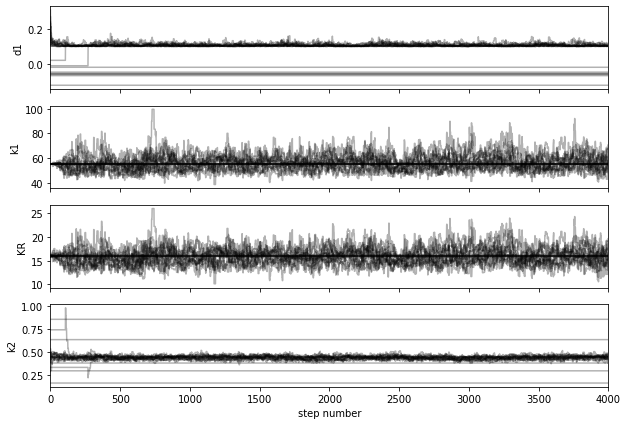

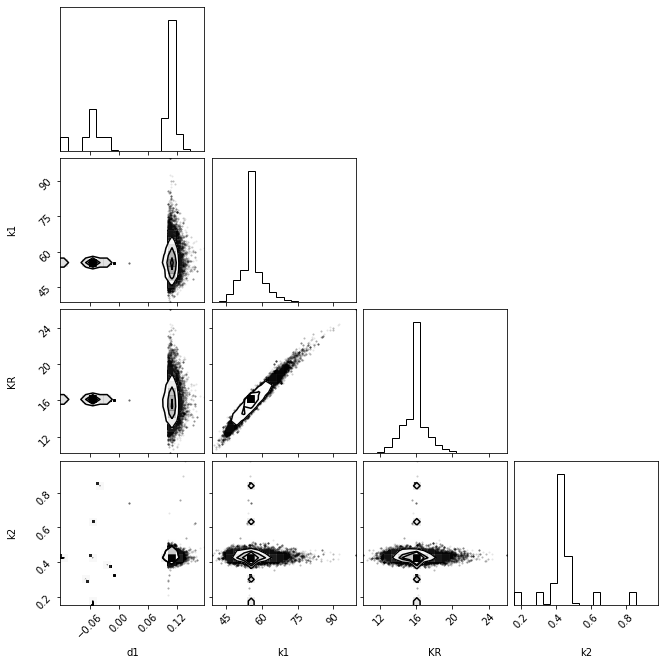

In [6]:
from bioscrape.inference import py_inference
prior = {'d1' : ['uniform', 0.1, 10], 'k1' : ['uniform',0,100], 'KR' : ['uniform',0,100], 'k2':['uniform', 0, 100]}

sampler, pid = py_inference(Model = M, exp_data = exp_data, measurements = ['X','Y'], time_column = ['timepoints'],
                            initial_conditions = initial_condition_list,
                            nwalkers = 20, init_seed = 0.15, nsteps = 4000, sim_type = 'deterministic',
                            params_to_estimate = ['d1','k1','KR', 'k2'], prior = prior, convergence_check = True)


Finally, bioscrape inference also allows stochastic simulations! So, you can run a stochastic inference by simply changing the `sim_type` argument to `stochastic` instead of `deterministic`. 

# Stochastic Inference 

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:31<00:00, 34.32it/s]


Successfully completed MCMC parameter identification procedure. Parameter distribution data written to mcmc_results.csv file. Check the MCMC diagnostics to evaluate convergence.
Parameter posterior distribution convergence plots:


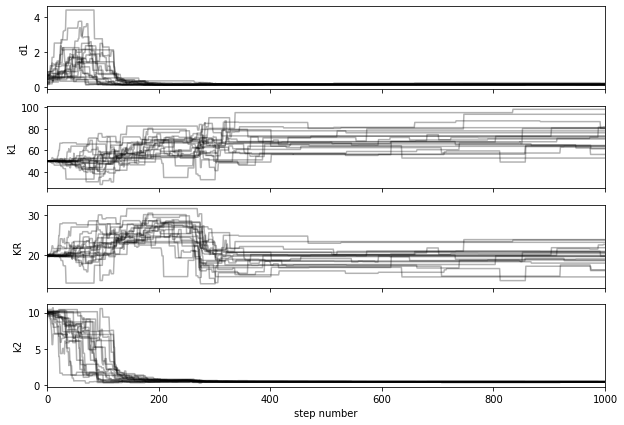

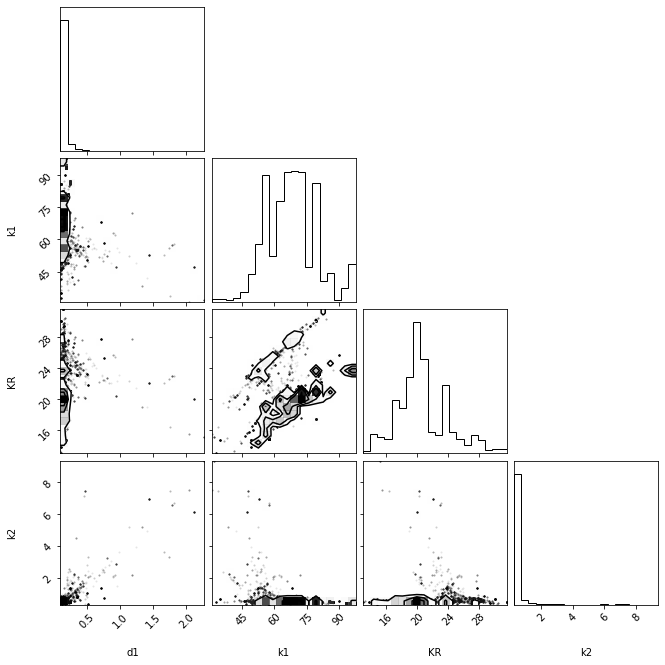

In [15]:
from bioscrape.inference import py_inference
prior = {'d1' : ['uniform', 0.1, 10], 'k1' : ['uniform',0,100], 'KR' : ['uniform',0,100], 'k2':['uniform', 0, 100]}

sampler, pid = py_inference(Model = M, exp_data = exp_data, measurements = ['X','Y'], time_column = ['timepoints'],
                            initial_conditions = initial_condition_list,
                            nwalkers = 20, init_seed = 0.15, nsteps = 1000, sim_type = 'stochastic',
                            params_to_estimate = ['d1','k1','KR', 'k2'], prior = prior, convergence_check = False)


That is not all though! Bioscrape Inference can do more:

## Maximum-Likelihood estimates (such as least-squares): Bioscrape Inference is compatible with the Python LMFit package. Check out the notebook: `OD data using least squares(LMFit example).ipynb`.

1. All examples above are available as individual notebooks at the following location: `bioscrape/inference examples/individual examples/`

Check out our Github page for more information: https://github.com/biocircuits/bioscrape/
